# IMPORTS

In [51]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU, MultiHeadAttention, GlobalAveragePooling1D, Input, LayerNormalization
from tensorflow.keras.models import Model

import plotly.graph_objects as go

# Setting up the database

In [10]:
df = pd.read_csv("../data/bitcoin.csv") 

In [24]:
display(df.info,
    df.dtypes)

<bound method DataFrame.info of           Fecha    Último  Apertura    Máximo    Mínimo      Vol.    % var.
0    2024-07-02  0.840296  0.840962  0.837762  0.863084  0.000011  0.444064
1    2024-07-01  0.840995  0.839094  0.846816  0.859303  0.000013  0.452340
2    2024-06-30  0.838873  0.811036  0.833887  0.829589  0.000008  0.529395
3    2024-06-29  0.811046  0.802139  0.805819  0.824447  0.000006  0.472888
4    2024-06-28  0.802138  0.822154  0.821024  0.819626  0.000013  0.386701
...         ...       ...       ...       ...       ...       ...       ...
1457 2020-07-06  0.004248  0.000208  0.003754  0.002101  0.000114  0.527112
1458 2020-07-05  0.000217  0.001050  0.000452  0.000000  0.000070  0.429509
1459 2020-07-04  0.001052  0.000000  0.000958  0.001883  0.000058  0.467180
1460 2020-07-03  0.000000  0.000280  0.000000  0.001904  0.000075  0.440354
1461 2020-07-02  0.000281  0.002544  0.002156  0.000481  0.000108  0.401256

[1462 rows x 7 columns]>

Fecha       datetime64[ns]
Último             float64
Apertura           float64
Máximo             float64
Mínimo             float64
Vol.               float64
% var.             float64
dtype: object

In [12]:
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d.%m.%Y')
df['Fecha'].dtype, df.head()


(dtype('<M8[ns]'),
        Fecha    Último  Apertura    Máximo    Mínimo    Vol.  % var.
 0 2024-07-02  62.845,4  62.888,3  63.257,0  62.794,0  47,35K  -0,07%
 1 2024-07-01  62.890,1  62.768,8  63.842,1  62.558,0  59,94K   0,22%
 2 2024-06-30  62.754,3  60.973,1  63.006,6  60.703,7  37,21K   2,92%
 3 2024-06-29  60.973,4  60.403,7  61.192,8  60.382,8  26,56K   0,94%
 4 2024-06-28  60.403,3  61.684,6  62.175,4  60.081,9  58,95K  -2,08%)

In [13]:
df['Último'] = df['Último'].str.replace('.', '').str.replace(',', '.').astype(float)
df['Apertura'] = df['Apertura'].str.replace('.', '').str.replace(',', '.').astype(float)
df['Máximo'] = df['Máximo'].str.replace('.', '').str.replace(',', '.').astype(float)
df['Mínimo'] = df['Mínimo'].str.replace('.', '').str.replace(',', '.').astype(float)
df['Vol.'] = df['Vol.'].str.replace('K', 'e3').str.replace('M', 'e6').str.replace('B', 'e9').str.replace('.', '').str.replace(',', '.').astype(float)
df['% var.'] = df['% var.'].str.replace('%', '').str.replace(',', '.').astype(float)

In [14]:
df.dtypes

Fecha       datetime64[ns]
Último             float64
Apertura           float64
Máximo             float64
Mínimo             float64
Vol.               float64
% var.             float64
dtype: object

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

columns_to_normalize = ["Último", "Apertura", "Máximo", "Mínimo", "Vol.", "% var."]

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df.head()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,2024-07-02,0.840296,0.840962,0.837762,0.863084,0.000011,0.444064
1,2024-07-01,0.840995,0.839094,0.846816,0.859303,0.000013,0.452340
2,2024-06-30,0.838873,0.811036,0.833887,0.829589,0.000008,0.529395
3,2024-06-29,0.811046,0.802139,0.805819,0.824447,0.000006,0.472888
4,2024-06-28,0.802138,0.822154,0.821024,0.819626,0.000013,0.386701


In [20]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

In [21]:
train_size = int(len(train_data) * 0.9)
train_set = train_data[:train_size]
val_set = train_data[train_size:]

In [23]:
display(len(train_set),
            len(val_set),
            len(test_data))

1052

117

293

In [27]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length].drop(columns=['Fecha']).values
        y = data.iloc[i+seq_length]['Último']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 30 

In [28]:
X_train, y_train = create_sequences(train_set, SEQ_LENGTH)
X_val, y_val = create_sequences(val_set, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1022, 30, 6) (1022,) (87, 30, 6) (87,) (263, 30, 6) (263,)


# Forecasting with Vanilla RNN

In [30]:
vanilla_rnn = Sequential([
    SimpleRNN(50, return_sequences=False, input_shape=(SEQ_LENGTH, 6)),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

vanilla_rnn.compile(optimizer='adam', loss='mean_squared_error')

vanilla_rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         2,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,151 (16.21 KB)

 Trainable params: 4,151 (16.21 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history_vanilla_rnn = vanilla_rnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

y_pred = vanilla_rnn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE for Vanilla RNN: {mse}")
print(f"Test RMSE for Vanilla RNN: {rmse}")
print(f"Test MAE for Vanilla RNN: {mae}")
print(f"Test R² for Vanilla RNN: {r2}")


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 4.7175e-04
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 1.6570e-04
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 3.2835e-04
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 1.1166e-04
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 1.2486e-04
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 1.9581e-04
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 2.1160e-04
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 1.1396e-04
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 2.1188e-04
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4907e-04 - val_loss: 1.2066e-04
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7874e-04 - val_loss: 1.2395e-04
Epoch 12/20
32/32 ━━━━

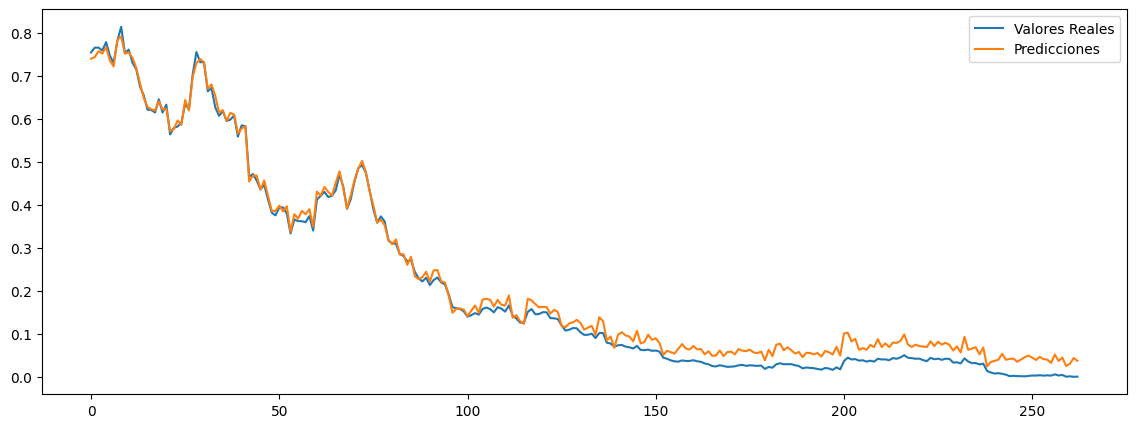

In [34]:
plt.figure(figsize=(14,5))
plt.plot(y_test, label='Valores Reales')
plt.plot(y_pred, label='Predicciones')
plt.legend()
plt.show()

In [38]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(len(y_test))), y=y_test, mode='lines', name='Valores Reales'))
fig.add_trace(go.Scatter(x=list(range(len(y_test))), y=y_pred.flatten(), mode='lines', name='Predicciones'))

fig.update_layout(
    title='Comparación de Valores Reales y Predicciones - Vanilla RNN',
    xaxis_title='Días',
    yaxis_title='Precio Normalizado de Bitcoin',
    legend=dict(x=0, y=1),
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey')
)

fig.show()


# Forecasting with LSTM/GRU

In [39]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 6)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.summary()

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history_lstm = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

y_pred_lstm = lstm_model.predict(X_test)

mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"Test MSE for LSTM: {mse_lstm}")
print(f"Test RMSE for LSTM: {rmse_lstm}")
print(f"Test MAE for LSTM: {mae_lstm}")
print(f"Test R² for LSTM: {r2_lstm}")

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0384 - val_loss: 0.0037
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057 - val_loss: 0.0028
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

In [42]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(len(y_test))), y=y_test, mode='lines', name='Valores Reales'))
fig.add_trace(go.Scatter(x=list(range(len(y_test))), y=y_pred_lstm.flatten(), mode='lines', name='Predicciones'))

fig.update_layout(
    title='Comparación de Valores Reales y Predicciones - LSTM',
    xaxis_title='Días',
    yaxis_title='Precio Normalizado de Bitcoin',
    legend=dict(x=0, y=1),
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey')
)

fig.show()


In [48]:
gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(SEQ_LENGTH, 6)),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mean_squared_error')

gru_model.summary()

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 50)         │         8,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,301 (98.83 KB)

 Trainable params: 25,301 (98.83 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history_gru = gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

y_pred_gru = gru_model.predict(X_test)

mse_gru = mean_squared_error(y_test, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
mae_gru = mean_absolute_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)

print(f"Test MSE for GRU: {mse_gru}")
print(f"Test RMSE for GRU: {rmse_gru}")
print(f"Test MAE for GRU: {mae_gru}")
print(f"Test R² for GRU: {r2_gru}")

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0872 - val_loss: 0.0045
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0070 - val_loss: 0.0011
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0034 - val_loss: 9.0853e-04
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030 - val_loss: 9.7972e-04
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 7.8279e-04
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 9.7222e-04
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0021 - val_loss: 4.4071e-04
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020 - val_loss: 9.6404e-04
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - val_loss: 2.9314e-04
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━

In [50]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(len(y_test))), y=y_test, mode='lines', name='Valores Reales'))
fig.add_trace(go.Scatter(x=list(range(len(y_test))), y=y_pred_gru.flatten(), mode='lines', name='Predicciones'))

fig.update_layout(
    title='Comparación de Valores Reales y Predicciones - GRU',
    xaxis_title='Días',
    yaxis_title='Precio Normalizado de Bitcoin',
    legend=dict(x=0, y=1),
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey')
)

fig.show()


# Forecasting with a Transformer

In [52]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = Dense(dim, activation='relu')(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

input_shape = (SEQ_LENGTH, 6)
head_size = 256
num_heads = 4
ff_dim = 256
num_transformer_blocks = 4
mlp_units = [128]
dropout = 0.2
mlp_dropout = 0.2

transformer_model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)

transformer_model.compile(optimizer='adam', loss='mean_squared_error')

transformer_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 30, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 6)     │         12 │ input_layer_4[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 6)     │     27,654 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 30, 6)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 6)     │          0 │ dropout_7[0][0],  │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 6)     │         12 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 30, 256)   │      1,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 30, 256)   │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 30, 6)     │      1,542 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 6)     │          0 │ dense_9[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 6)     │         12 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 6)     │     27,654 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 30, 6)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 6)     │          0 │ dropout_10[0][0], │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 6)     │         12 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 30, 256)   │      1,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 30, 256)   │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 30, 6)     │      1,542 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 30, 6)     │          0 │ dense_11[0][0], 

 Total params: 125,073 (488.57 KB)

 Trainable params: 125,073 (488.57 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history_transformer = transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

y_pred_transformer = transformer_model.predict(X_test)

mse_transformer = mean_squared_error(y_test, y_pred_transformer)
rmse_transformer = np.sqrt(mse_transformer)
mae_transformer = mean_absolute_error(y_test, y_pred_transformer)
r2_transformer = r2_score(y_test, y_pred_transformer)

print(f"Test MSE for Transformer: {mse_transformer}")
print(f"Test RMSE for Transformer: {rmse_transformer}")
print(f"Test MAE for Transformer: {mae_transformer}")
print(f"Test R² for Transformer: {r2_transformer}")

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.0575 - val_loss: 0.0056
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0112 - val_loss: 0.0084
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0077 - val_loss: 0.0212
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0063 - val_loss: 0.0085
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0058 - val_loss: 0.0124
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0065 - val_loss: 0.0138
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0053 - val_loss: 0.0107
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0048 - val_loss: 0.0082
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0052 - val_loss: 0.0138
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0041 - val_loss: 0.0188
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0042 - val_loss: 0.0102
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss:

In [54]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(len(y_test))), y=y_test, mode='lines', name='Valores Reales'))
fig.add_trace(go.Scatter(x=list(range(len(y_test))), y=y_pred_transformer.flatten(), mode='lines', name='Predicciones'))

fig.update_layout(
    title='Comparación de Valores Reales y Predicciones - Transformer',
    xaxis_title='Días',
    yaxis_title='Precio Normalizado de Bitcoin',
    legend=dict(x=0, y=1),
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey')
)

fig.show()


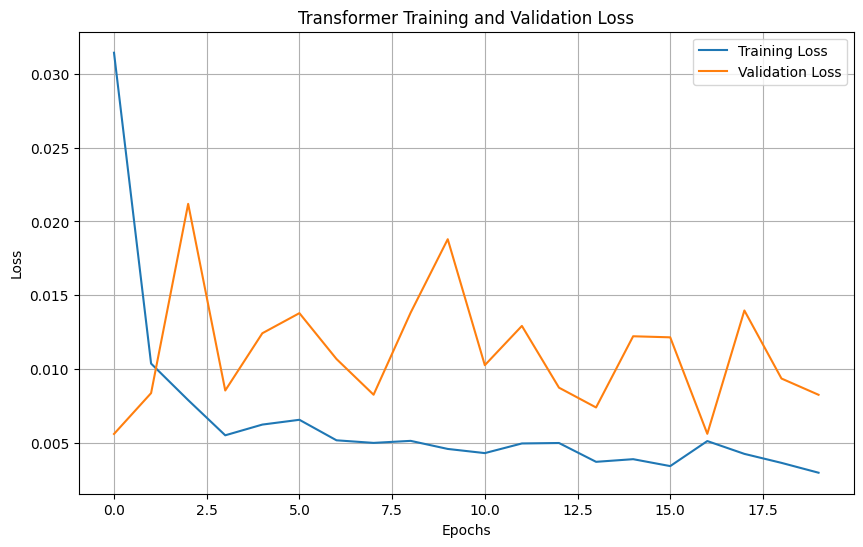

In [55]:
def plot_loss(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history_transformer, 'Transformer Training and Validation Loss')

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.2192 - val_loss: 0.0074
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0293 - val_loss: 0.0104
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0174 - val_loss: 0.0196
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0165 - val_loss: 0.0125
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0126 - val_loss: 0.0170
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0140 - val_loss: 0.0182
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0135 - val_loss: 0.0100
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0153 - val_loss: 0.0428
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0173 - val_loss: 0.0185
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0112 - val_loss: 0.0271
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0106 - val_loss: 0.0292
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0

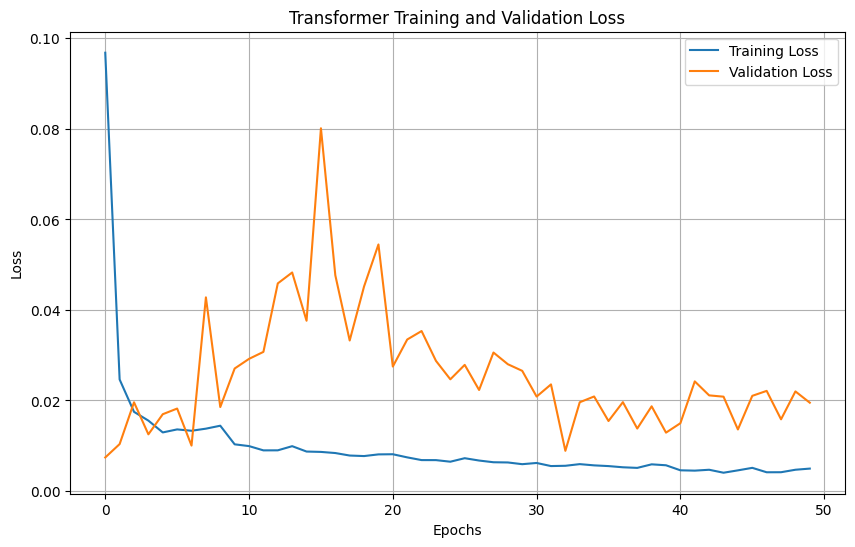

In [57]:
# adjust

input_shape = (SEQ_LENGTH, 6)
head_size = 128
num_heads = 4
ff_dim = 128
num_transformer_blocks = 2
mlp_units = [64]
dropout = 0.4  
mlp_dropout = 0.4 

transformer_model_adjusted = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)

transformer_model_adjusted.compile(optimizer='adam', loss='mean_squared_error')

history_transformer_adjusted = transformer_model_adjusted.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

y_pred_transformer_adjusted = transformer_model_adjusted.predict(X_test)

mse_transformer_adjusted = mean_squared_error(y_test, y_pred_transformer_adjusted)
rmse_transformer_adjusted = np.sqrt(mse_transformer_adjusted)
mae_transformer_adjusted = mean_absolute_error(y_test, y_pred_transformer_adjusted)
r2_transformer_adjusted = r2_score(y_test, y_pred_transformer_adjusted)

print(f"Test MSE for Adjusted Transformer: {mse_transformer_adjusted}")
print(f"Test RMSE for Adjusted Transformer: {rmse_transformer_adjusted}")
print(f"Test MAE for Adjusted Transformer: {mae_transformer_adjusted}")
print(f"Test R² for Adjusted Transformer: {r2_transformer_adjusted}")

plot_loss(history_transformer_adjusted, 'Transformer Training and Validation Loss')

In [61]:
from sklearn.model_selection import ParameterGrid

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'head_size': [64, 128, 256],
    'num_heads': [2, 4, 8],
    'ff_dim': [128, 256, 512],
    'num_transformer_blocks': [2, 4, 6],
    'dropout': [0.2, 0.3, 0.4],
    'mlp_dropout': [0.2, 0.3, 0.4]
}

# Crear todas las combinaciones de parámetros
grid = ParameterGrid(param_grid)

best_params = None
best_r2 = -np.inf

for params in grid:
    # Crear el modelo con la combinación actual de hiperparámetros
    transformer_model = build_transformer_model(
        input_shape=(SEQ_LENGTH, 6),
        head_size=params['head_size'],
        num_heads=params['num_heads'],
        ff_dim=params['ff_dim'],
        num_transformer_blocks=params['num_transformer_blocks'],
        mlp_units=[params['ff_dim']],
        dropout=params['dropout'],
        mlp_dropout=params['mlp_dropout']
    )
    
    # Compilar el modelo
    transformer_model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Entrenar el modelo
    history = transformer_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluar el modelo
    y_pred = transformer_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    # Guardar la mejor combinación de hiperparámetros
    if r2 > best_r2:
        best_r2 = r2
        best_params = params

print(f"Best R²: {best_r2}")
print(f"Best Parameters: {best_params}")


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1921 - val_loss: 0.0087
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143 - val_loss: 0.0087
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - val_loss: 0.0121
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - val_loss: 0.0093
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - val_loss: 0.0090
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - val_loss: 0.0190
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - val_loss: 0.0155
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - val_loss: 0.0191
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - val_loss: 0.0103
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043 - v

KeyboardInterrupt: 

# Analysis and comparison